# Proyecto de Máquinas de Aprendizaje - ILI393
## _Identificación facial cuando existen pocas muestras por clase_

## El Problema

El problema consiste en la correcta identificación y reconocimiento facial, dado el caso particular en donde existen muy pocas muestras por clase (por persona) para entrenar los algoritmos algoritmos de clasificación. La mayoría de los enfoques usados en este tipo de problemas consisten en encontrar una buena representación de las características importantes de las caras, para posteriormente realizar algún tipo de búsqueda (jerárquica, nearest neighbors, etc). Sin embargo se propone aquí resolver el problema con tres algoritmos de clasificación distintos: Linear Discriminant Analysis, Support Vector Machines (con kernel lineal y radio basal) y por Convolutional Neural Networks.

Los dataset a ocupar son [Faces94](http://cswww.essex.ac.uk/mv/allfaces/faces94.html), [Faces95](http://cswww.essex.ac.uk/mv/allfaces/faces95.html) y [Faces96](http://cswww.essex.ac.uk/mv/allfaces/faces96.html). Cada uno de los datasets consiste en 20 imágenes de individuos, y variable cantidad de individuos. Los datasets están ordenados en cuanto a su complejidad de reconocimiento de menor a mayor. Se muestran a continuación imágenes representativas de Faces94, Faces95 y Faces96 respectivamente.

<img src="faces94ex.jpg">

<img src="faces95ex.jpg">

<img src="faces96ex.jpg">

Para cada uno de estos datasets, se crearon los 20 training y testing sets correspondientes. La metodología fue la siguiente: Para cada dataset (94,95,96) se tomaron aleatoriamente entre 2-5 fotos por clase (por persona) para formar los training sets correspondientes, y las restantes 15-18 fotos se dejaron para crear los testing sets correspondientes. Vale decir, si se entrena con train94/5pc (faces94, 5 samples per class) entonces se prueba con test94/15pc (faces94, 15 samples per class). Cumpliendo de este modo con la restricción de tener pocos samples para entrenar los algoritmos.
**Observación**: Por el momento se trabaja sólo con Faces94 y Faces95.

Para la comparación entre los resultados de los distintos algoritmos, se realizan *Error Bars* del error rate sobre los 20 datasets. Para computar las barras de error, se computan según el intervalo de confianza del 95% para la media del error, por medio de la distribución t-student.

## Enfoque 1: Linear Discriminant Analysis

La implementación ocupada corresponde la de Scikit-Learn. Para cada una de las clases (personas) genera la función discriminante lineal $\delta_k$, que permite diferenciar a cada una de las clases. Los dos supuestos fuertes que se realizan sobre los datasets al ocupar este método, son que 1) La probabilidad multivariada de las características $P(x_m | y=k)$ se distribuye normal, y que 2) La matriz de covarianza para cada una de las clases es igual.

Debido a que LDA es un modelo generativo sin _hiperparámetros_, es que no es necesario realizar cross-validation para el modelo. Esto es una gran ventaja, pues ahora gran tiempo de computación (comparado con los otros métodos). Sin embargo, como se verá más adelante, paga este costo de simplicidad, entregando resultados menos precisos y generalizantes.

### 1) LDA con Faces94

In [11]:
lda_tr_err_faces94_3spc, lda_ts_err_faces94_3spc = solve_lda('faces94', 3, verbose=False)
lda_tr_err_faces94_4spc, lda_ts_err_faces94_4spc = solve_lda('faces94', 4, verbose=False)
lda_tr_err_faces94_5spc, lda_ts_err_faces94_5spc = solve_lda('faces94', 5, verbose=False)
tr_errors_lda_faces94 = [lda_tr_err_faces94_3spc, lda_tr_err_faces94_4spc, lda_tr_err_faces94_5spc]
ts_errors_lda_faces94 = [lda_ts_err_faces94_3spc, lda_ts_err_faces94_4spc, lda_ts_err_faces94_5spc]

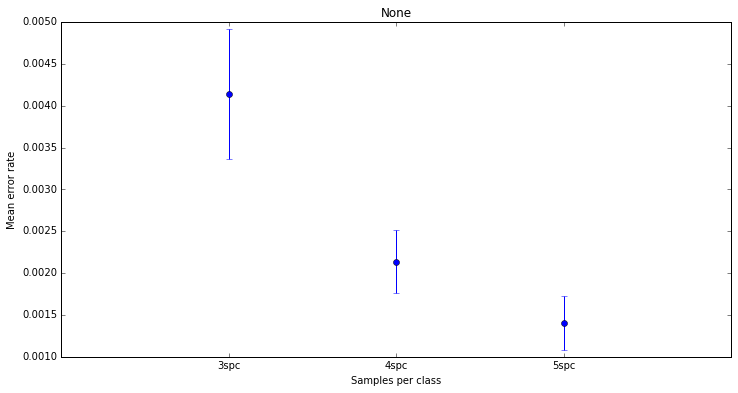

In [14]:
plot_errorbars(ts_errors_lda_faces94)

**Análisis:**
+ De los gráficos, se nota que el dataset Faces94 es muy "fácil" y por lo tanto los resultados son casi perfectos. Si se revisan las imagenes en este, puede notarse que las imagenes para una misma persona son todas muy parecidas, es decir, hay poca variación en la pose, expresión, iluminación, etc. Por lo cual esta data es fácilmente separable por hiperplanos.
+ De todos modos, a medida que aumentan las muestras por clase, el error rate tiende a disminuir.

### LDA con Faces95

In [15]:
lda_tr_err_faces95_3spc, lda_ts_err_faces95_3spc = solve_lda('faces95', 3, verbose=False)
lda_tr_err_faces95_4spc, lda_ts_err_faces95_4spc = solve_lda('faces95', 4, verbose=False)
lda_tr_err_faces95_5spc, lda_ts_err_faces95_5spc = solve_lda('faces95', 5, verbose=False)
tr_errors_lda_faces95 = [lda_tr_err_faces95_3spc, lda_tr_err_faces95_4spc, lda_tr_err_faces95_5spc]
ts_errors_lda_faces95 = [lda_ts_err_faces95_3spc, lda_ts_err_faces95_4spc, lda_ts_err_faces95_5spc]

/home/martin/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


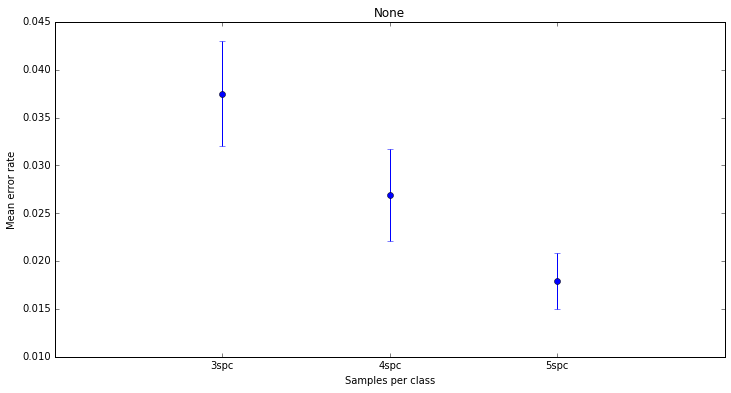

In [16]:
plot_errorbars(tr_errors_lda_faces95)

**Análisis:**
+ Se nota claramente que el dataset Faces95 es un dataset mucho más complejo que el anterior.
+ Los error rates son claramente mayores, siendo estos muy altos para los casos en donde hay pocos ejemplos por clase.
+ De todas maneras el comportamiento tiende a mejorar cuando existen más muestras por clase.

## Enfoque 2: Support Vector Machines

### Marco Teórico

Support Vector Machines (SVM) es un método de clasificación binario (adaptable a problemas de múltiples clases), que encuentra la frontera de decisión lineal óptima (hiperplano óptimo) que separa a las clases. Intuituvamente, una buena separación es lograda por el hiperplano con mayor distancia o margen a los datos de entramiento más cercanos. Esta superficie de separación es una combinación lineal de elementos del training set, conocidos como vectores de soporte, pues definen la frontera entre dos clases
<img src="separating_hyperplane.png" style="width: 500px;">

Por lo tanto el método se reduce a el problema de optimización, de encontrar el hiperplano $\mathbf{w}^T x + b = 0$ que maximice el margen de cada ejemplo en el training set. Esto puede expresarse mas formalmente como:
\begin{align}
& \min_{\mathbf{w},b} \frac{1}{2} ||\mathbf{w}||^2 \\
& \text{s.t } \ y_m(\mathbf{w}^T x_m + b) \geq 1, \ m=1,\ldots ,M 
\end{align}

lo cual corresponde a un problema de optimización cuadrático. Es posible relajar algunas reestricciones del problema introduciendo *variables de holgura*
\begin{align}
& \min_ {\mathbf{w}, b, \zeta} \frac{1}{2} ||\mathbf{w}||^2 + C \sum_{m=1}^{M} \zeta_i \\
& \text{s.t } \ y_m (\mathbf{w}^T \ x_m + b) \geq 1 - \zeta_m,\\
& \zeta_m \geq 0, m=1, ..., M
\end{align}

donde el parámetro C controla el trade-off entre el error de clasificación y el tamaño del margen. En general a mayor margen, menor será el error de generalización del clasificador, por lo tanto con las *variables de holgura* se tiene una manera de controlar esta relación.

La SVM determinada por el anterior problema de optimización es conocida como la C-SVM. Sin embargo por medio de una re-parametrización de esta, es posible definir un nuevo parámetros $\nu$ que controla el número de vectores de soporte y el error de entrenamiento. Esta formulación corresponde a la $\nu$-SVM y puede ser demostrado que ambas formulaciones son matemáticamente equivalentes.

### Experimentación

El enfoque seguido en esta sección, es la implementación y entrenamiento de multiclass SVM's con kernels tanto lineales como gaussianos, para cumplir con el objetivo de clasificar la data. Para ello se ocupan $\nu$-SMV's, debido a que facilita la configuración del parámetro de holgura $\nu$. La implementación ocupada corresponde a la de Scikit-Learn, el cual advierte: _“SVC  implement one-against-one” approach (Knerr et al., 1990) for multi- class classification."_

Para la selección de _hiperparámetros_ $\nu$ y $\gamma$ (en kernels rbf) se realiza *stratified cross-validation* sobre cada training set, con la ayuda de grid search. Para que este método tenga sentido, el número de folds debe ser igual al número de muestras por clase (si hay más folds que muestras por clase, no se pueden cumplir las condiciones de estratificación).

Debido a que las dimensiones de las imágenes (200x180=36000) corresponden al total de features de cada foto, se ha decidido realizar una reducción de dimensionalidad para mejorar los tiempos de entrenamientos y eficiencia, así como también tomar las características realmente importantes (aquellas que permiten diferencias entre las clases).

Como técnica de reducción de dimensionalidad, se ha decidido ocupar LDA como reducción de dimensionalidad supervisada, representación tambien conocida como [_Fisher Faces_](http://www.scholarpedia.org/article/Fisherfaces). Esta técnica
intenta encontrar un subespacio donde proyectar la data que permita diferenciar de mejor manera las clases. Dicho de otro modo, se intenta maximizar la **inter-class variance**  y minimizar la varianza **intra-class variance**.

Básicamente los hiperplanos que conforman el subespacio de representación, corresponden a la funciones discriminantes que genera el modelo en LDA. La idea se plasma en la siguiente representación

<img src="lineardisc.jpg">

en donde cada dato se proyecta en los hiperplanos discriminantes, para formar la representación. El número de máximo de discriminantes es $\min(\text{dimensiones},\text{clases}-1)$, por lo tanto en un problema con muchas más dimensiones (features) que clases, la reducción de dimensionalidad es considerablemente favorable (este problema es precisamente el caso). Se pueden ocupar menos discriminantes, pero para los experimentos que se muestran a continuación se ocupan todos.

### 1) Linear SVM

**Observaciones:**
+ Los rangos de los parámetros fueron determinados empíricamente, probando aquellos que entregan resultados coherentes y útiles en los datasets respectivos.

In [17]:
#Setting parameters to try on Linear-SVM for Faces94 and Faces95
Nu = np.linspace(0.0005, 0.001, 5, endpoint=True)

### Linear-SVM con Faces94

In [18]:
lsvm_tr_err_faces94_3spc, lsvm_ts_err_faces94_3spc = solve_svm('faces94', 3, 'linear', Nu, verbose=False)
lsvm_tr_err_faces94_4spc, lsvm_ts_err_faces94_4spc = solve_svm('faces94', 4, 'linear', Nu, verbose=False)
lsvm_tr_err_faces94_5spc, lsvm_ts_err_faces94_5spc = solve_svm('faces94', 5, 'linear', Nu, verbose=False)
tr_errors_lsvm_faces94 = [lsvm_tr_err_faces94_3spc, lsvm_tr_err_faces94_4spc, lsvm_tr_err_faces94_5spc]
ts_errors_lsvm_faces94 = [lsvm_ts_err_faces94_3spc, lsvm_ts_err_faces94_4spc, lsvm_ts_err_faces94_5spc]

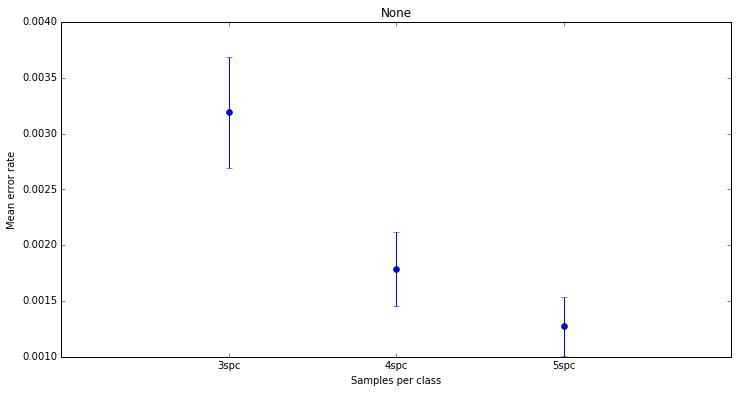

In [19]:
plot_errorbars(ts_errors_lsvm_faces94)

El gráfico a continuación compara los resultados recien obtenidos, con los resultados de los algoritmos anteriores para el dataset Faces94

<img src="comp1.png">

**Análisis:**
+ Sucede lo mismo que con LDA: Faces94 es muy fácil de separar por hiperplanos, y por lo tanto obtiene un buen resultado también con la SVM de kernel lineal.
+ Los error rates obtenidos aquí son ligeramente inferiores a los obtenidos con LDA.
+ Sigue el patrón de mejorar los resultados a medida que aumentan las muestras por clase.

### Linear-SVM con Faces95

In [20]:
lsvm_tr_err_faces95_3spc, lsvm_ts_err_faces95_3spc = solve_svm('faces95', 3, 'linear', Nu, verbose=False)
lsvm_tr_err_faces95_4spc, lsvm_ts_err_faces95_4spc = solve_svm('faces95', 4, 'linear', Nu, verbose=False)
lsvm_tr_err_faces95_5spc, lsvm_ts_err_faces95_5spc = solve_svm('faces95', 5, 'linear', Nu, verbose=False)
tr_errors_lsvm_faces95 = [lsvm_tr_err_faces95_3spc, lsvm_tr_err_faces95_4spc, lsvm_tr_err_faces95_5spc]
ts_errors_lsvm_faces95 = [lsvm_ts_err_faces95_3spc, lsvm_ts_err_faces95_4spc, lsvm_ts_err_faces95_5spc]

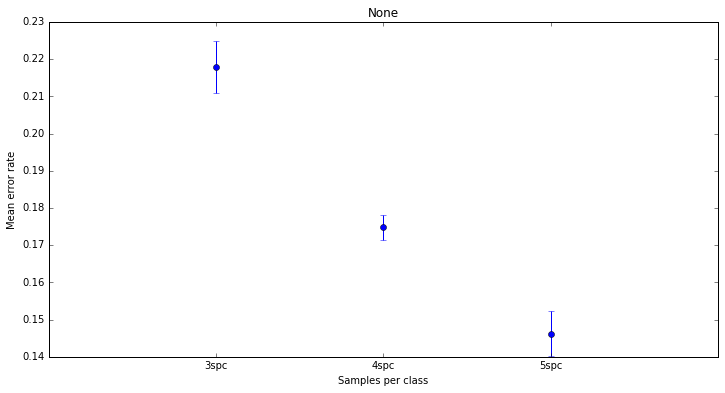

In [21]:
plot_errorbars(ts_errors_lsvm_faces95)

El gráfico a continuación compara los resultados recien obtenidos, con los resultados de los algoritmos anteriores para el dataset Faces95

<img src="comp2.png">

**Análisis:**
+ Los resultados aquí obtenidos, mejoran en una cantidad notoria respecto a el mismo dataset aplicado con LDA. Sin embargo, no hay que olvidar que aquí se tuvo que realizar un proceso de cross-validation para establecer _hiperparámetros_ y en LDA no.
+ La mejor capacidad de generalización obtenida por la SVM, refleja los beneficios de tener variables de holgura, esto es, permitir cometer ciertos errores en el training set, para asi aumentar el margen junto con la capacidad de generalizar en el testing set.
+ Se mantiene el patrón de mejorar los resultados a medida que aumentan los ejemplos por clase.

### 2) Kernel-SVM

**Observaciones:**
+ Los rangos de los parámetros fueron determinados empíricamente, probando aquellos que entregan resultados coherentes y útiles en los datasets respectivos.

In [ ]:
#setting parameters to try one kernel-svm
Nu = np.linspace(0.0005, 0.01, 10, endpoint=True)
Gamma = np.linspace(0.25, 2.0, 10, endpoint=True)

### Kernel-SVM con Faces94 

In [ ]:
ksvm_tr_err_faces94_3spc, ksvm_ts_err_faces94_3spc = solve_svm('faces94', 3, 'rbf', Nu, Gamma, verbose=False)
ksvm_tr_err_faces94_4spc, ksvm_ts_err_faces94_4spc = solve_svm('faces94', 4, 'rbf', Nu, Gamma, verbose=False)
ksvm_tr_err_faces94_5spc, ksvm_ts_err_faces94_5spc = solve_svm('faces94', 5, 'rbf', Nu, Gamma, verbose=False)
tr_errors_ksvm_faces94 = [ksvm_tr_err_faces94_3spc, ksvm_tr_err_faces94_4spc, ksvm_tr_err_faces94_5spc]
ts_errors_ksvm_faces94 = [ksvm_ts_err_faces94_3spc, ksvm_ts_err_faces94_4spc, ksvm_ts_err_faces94_5spc]

In [ ]:
plot_errorbars(ts_errors_ksvm_faces94)

El gráfico a continuación compara los resultados recien obtenidos, con los resultados de los algoritmos anteriores para el dataset Faces94

<img src="comp3.png">

**Análisis:**
+ Sorprendentemente, los resultados son signigicativamente peores que con los otros dos algoritmos anteriores. Peor aun, el error en vez de disminiur a medida que aumentan las muestras por clase, aumenta.
+ La explicación más probable de este fenómeno, es overfitting. Como sabemos, con un kernel gaussiano se da la posibilidad de aprender fronteras de decisión no lineales complejas. Sin embargo sabemos que este dataset es muy bien separable por hiperplanos, por lo tanto el hecho de agregarle complejidad, sólo empeoró la situación.
+ Adicionalmente el hecho de que el error aumente con las muestras por clase, es un reflejo de lo descrito anteriormente. Mientras más muestras por clase existe, va a generar un modelo no lineal más y más complejo, lo cual para efectos de este dataset, es algo malo.

### Kernel-SVM con Faces95

In [ ]:
#setting parameters to try one kernel-svm
Nu = np.linspace(0.0005, 0.01, 10, endpoint=True)
Gamma = np.linspace(0.25, 2.0, 10, endpoint=True)

In [ ]:
ksvm_tr_err_faces95_3spc, ksvm_ts_err_faces95_3spc = solve_svm('faces95', 3, 'rbf', Nu, Gamma, verbose=False)
ksvm_tr_err_faces95_4spc, ksvm_ts_err_faces95_4spc = solve_svm('faces95', 4, 'rbf', Nu, Gamma, verbose=False)
ksvm_tr_err_faces95_5spc, ksvm_ts_err_faces95_5spc = solve_svm('faces95', 5, 'rbf', Nu, Gamma, verbose=False)
tr_errors_ksvm_faces95 = [ksvm_tr_err_faces95_3spc, ksvm_tr_err_faces95_4spc, ksvm_tr_err_faces95_5spc]
ts_errors_ksvm_faces95 = [ksvm_ts_err_faces95_3spc, ksvm_ts_err_faces95_4spc, ksvm_ts_err_faces95_5spc]

In [ ]:
plot_errorbars(ts_errors_ksvm_faces95)

El gráfico a continuación compara los resultados recien obtenidos, con los resultados de los algoritmos anteriores para el dataset Faces95

<img src="comp4.png">

**Análisis:**
+ Los resultados no son mejores que los obtenidos con los algoritmos anteriores, pero sin embargo no son tan malos como resulto en Faces94. Esto pues Faces95 es sabido un dataset más complejo, y por lo tanto un modelo de mayor complejidad (que uno lineal) puede ayudar. 
+ Los resultados podrían mejorar aún más si se realiza las selección de _hiperparámetros_ en una malla más fina, pero esto requeriría de mucho tiempo de computación.

## Enfoque 3: Convolutional Neural Network

In [ ]:
#loading the results

## Enfoque 4: Dissimilarity SVM

### Marco Teórico

#### Representación

El problema de *identificación* tratado corresponde a dada una imagen de prueba $\mathbf{p}$, determinar a qué clase del conjunto de entrenamiento $S_{tr}$ corresponde. Los enfoques basado en SVM anteriores, reducen este problema a $K$-class classification.

El propósito del método planteado, es ocupar las capacidades de clasificación de las SVM como clasificador binario, sobre dos conjuntos $C_1$ y $C_2$, donde el primero corresponde al *within-class differences set* que contienen las disimilitudes entre datos de la misma clase, y el segundo es *between-class difference set* y contienen las disimilitudes entre datos de distinta clase. El espacio en el que habitan los elementos de estos conjuntos, es conocido como el *difference space*, y contrasta con el espacio standard de las imágenes conocido como *image space*.

Formalizando lo anterior; sea $S_{tr} = \{\mathbf{s}_1 , \ldots, \mathbf{s}_M \}$ el conjunto de entrenamiento con imágenes faciales de $K$ individuos. Para indicar que dos individuos pertenecen a la misma clase ocuparemos $\mathbf{s}_i \sim \mathbf{s}_j$, y en caso contrario $\mathbf{s}_i \nsim \mathbf{s}_j$. Se define adicionalmente la función de similitud $\phi : R^N \times R^N \rightarrow R^S$ con $S \leq N$, como aquella función que mapea dos images, hacia el *difference space*. Luego es posible definir
\begin{align}
& C_1 = \{\phi(\mathbf{s}_i, \mathbf{s}_j)\  | \ \mathbf{s}_i \sim \mathbf{s}_j \} \\
& C_2 = \{\phi(\mathbf{s}_i, \mathbf{s}_j)\  | \ \mathbf{s}_i \nsim \mathbf{s}_j \}
\end{align}

#### Entrenamiento

Para el entrenamiento de la D-SVM (Dissimilarity SVM) los conjuntos de entrada son $C_1$ y $C_2$, es decir, se realiza un simple entrenamiento para clasificación binaria, lo cual es bastante conveniente.

Adicionalmente, sabemos que el output de una SVM es un conjunto de $M_s$ vectores de soporte $\mathbf{v}_m$, coeficientes $\alpha_m$, etiquetas de las clases $y_m$ de los vectores de soporte y el término $b$ constante. Luego la superficie de decisión puede ser escrita como
$$
f(\mathbf{x}) = \sum_m^{M_s} \alpha_m y_m K(\mathbf{v}_m, \mathbf{x}) + b = 0
$$

donde $K(\cdot,\cdot)$ es una función de kernel de acuerdo al Mercer's Theorem. Para $f(\mathbf{x}_i)<0$, mientras más grande sea el valor de $|f(\mathbf{x_i})|$, más es el grado (o probabilidad) de pertenencia de $\mathbf{x}_i$ a la primera clase (de modo análogo se concluye para la segunda clase). Por lo tanto se puede ocupar la función $f$ como discriminante, o como score de pertenencia a una clase.

In [103]:
#setting parameters to try one kernel-svm
#N = np.array([4,8,12,16,20])
#Nu = np.linspace(0.1, 0.5, 5, endpoint=True)
#Gamma = np.linspace(0.25, 2.0, 5, endpoint=True)

In [ ]:
dsvm_tr_err_faces94_3spc, dsvm_ts_err_faces94_3spc = solve_dsvm('faces94', 3, verbose=False)
dsvm_tr_err_faces94_4spc, dsvm_ts_err_faces94_4spc = solve_dsvm('faces94', 4, verbose=False)
dsvm_tr_err_faces94_5spc, dsvm_ts_err_faces94_5spc = solve_dsvm('faces94', 5, verbose=False)
tr_errors_dsvm_faces94 = [dsvm_tr_err_faces94_3spc, dsvm_tr_err_faces94_4spc, dsvm_tr_err_faces94_5spc]
ts_errors_dsvm_faces94 = [dsvm_ts_err_faces94_3spc, dsvm_ts_err_faces94_4spc, dsvm_ts_err_faces94_5spc]

In [ ]:
dsvm_tr_err_faces95_3spc, dsvm_ts_err_faces95_3spc = solve_dsvm('faces95', 3, verbose=False)
dsvm_tr_err_faces95_4spc, dsvm_ts_err_faces95_4spc = solve_dsvm('faces95', 4, verbose=False)
dsvm_tr_err_faces95_5spc, dsvm_ts_err_faces95_5spc = solve_dsvm('faces95', 5, verbose=False)
tr_errors_dsvm_faces95 = [dsvm_tr_err_faces95_3spc, dsvm_tr_err_faces95_4spc, dsvm_tr_err_faces95_5spc]
ts_errors_dsvm_faces95 = [dsvm_ts_err_faces95_3spc, dsvm_ts_err_faces95_4spc, dsvm_ts_err_faces95_5spc]

In [ ]:
plot_errorbars(ts_errors_dsvm_faces94)

In [ ]:
plot_errorbars(ts_errors_dsvm_faces95)

## Anexo de Código

### Configuración del notebook

In [ ]:
%matplotlib inline
import os
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import cv2 as cv
from sklearn import svm, grid_search
from sklearn.cross_validation import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClassifierMixin


#libraries for proposed approach
import histogram #own library
from sklearn.metrics.pairwise import chi2_kernel
from skimage.feature import local_binary_pattern as lbp

### Helper functions

In [2]:
"""
> function to load data from path directory to a matrix.
> each row of the resulting matrix, corresponds to a flattened image
  in grayscale format
"""
def load_data(path, stacked=False):
    #total number of classes
    M = len(os.listdir(path))
    #dimensions of each image
    N = 200*180
    #samples per class
    spc = int(path.strip().split('-')[1][:-2])
    #matrix with features
    if stacked:
        data = np.empty((M*spc,200,180), dtype=np.float32)
    else: 
        data = np.empty((M*spc,N), dtype=np.float32)
    labels = np.empty(M*spc, dtype=np.uint8)
    #index of data matrix
    m = 0
    for i in xrange(1,M+1):
        tgt = path+str(i)+'/'
        pics = os.listdir(tgt)
        for pic in pics:
            if stacked:
                #store each image, as a bidimensional array in data matrix
                data[m,:,:] = cv.imread(tgt+pic, cv.IMREAD_GRAYSCALE)
            else:
                #store each flattened image, as a row in data matrix
                data[m,:] = cv.imread(tgt+pic, cv.IMREAD_GRAYSCALE).ravel()
            labels[m] = i
            m += 1
    return (data, labels)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(15,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def make_hist(winners,params):
    for key in winners:
        par = params[key]
        win = np.array(winners[key])
        freqs = np.zeros(5)
        for i in xrange(5):
            freqs[i] = np.sum(par[i]==win)
        labels = map(str,par)
        pos = np.arange(len(labels))
        width = 1.0
        fig = plt.figure()
        fig.set_figheight(6)
        fig.set_figwidth(6)
        ax = plt.axes()
        ax.set_xticks(pos + (width / 2))
        ax.set_xticklabels(labels)
        plt.xlabel('Parameters')
        plt.ylabel('Frequency')
        plt.title('Histogram of {0}'.format(key))
        plt.bar(pos, freqs, width, color='0.5')
        plt.show()

def mean_confidence_interval(data, confidence=0.9):
    #computing confidence interval
    n = data.shape[0]
    mu = np.mean(data)
    sem = sp.stats.sem(data)
    h1,h2 = sp.stats.t.interval(confidence, n-1, loc=mu, scale=sem)
    return mu, h1, h2

def mean_percentile(data, inf=10, sup=90):
    mu = np.mean(data)
    h1, h2 = np.percentile(data, [10,90])
    return mu, h1, h2

def plot_errorbars(errors, title=None):
    mean = []
    lower = []
    upper = []
    for error in errors:
        mu,l,u = mean_confidence_interval(error)
        mean.append(mu)
        lower.append(l)
        upper.append(u)
    x = np.arange(3, len(errors)+3)
    mean = np.array(mean)
    lower = mean-np.array(lower)
    upper = np.array(upper)-mean
    labels = ['3spc','4spc','5spc']
    plt.figure(figsize=(12,6))
    plt.xlim([2,6])
    plt.xticks(x, labels)
    plt.errorbar(x, mean, yerr=[lower,upper],fmt='o')
    plt.xlabel('Samples per class')
    plt.ylabel('Mean error rate')
    plt.title(title)
    plt.show()

### Funciones de error

In [3]:
def precision(y_ts, y_pd):
    #true positives
    tp = (y_ts==y_pd).sum()
    #total of predictions
    n = y_ts.shape[0]
    return tp/np.float(n)

def error_rate(y_ts, y_pd):
    return 1-precision(y_ts, y_pd)

### Funciones para LDA

In [10]:
def solve_lda(dataset, spc, verbose=False):
    #samples per class on training set
    spc_tr = spc
    spc_ts = 20-spc_tr
    #training and testing paths
    tr_path = './db/train'+dataset[-2:]+'/tr-{0}pc-{1}/'
    ts_path = './db/test'+dataset[-2:]+'/ts-{0}pc-{1}/'
    #errors through all datasets
    tr_err = list()
    ts_err = list()
    #iterating through datasets
    for set_num in xrange(20):
        #loading training and testing set
        X_tr,y_tr = load_data(tr_path.format(spc_tr,set_num))
        X_ts,y_ts = load_data(ts_path.format(spc_ts,set_num))
        #creating LDA object and fitting the testing data
        clf = LDA()
        clf.fit(X_tr, y_tr)
        #computing training error
        tr_err.append(1.-clf.score(X_tr,y_tr))
        #computing testing error
        ts_err.append(1.-clf.score(X_ts,y_ts))
        if verbose:
            print "#####################################################################################"
            print "{0}: {1} samples per class (dataset {2})".format(dataset, spc, set_num)
            print "Training error rate: {0}".format(tr_err[-1])
            print "Testing error rate: {0}".format(ts_err[-1])
        #releasing memory of big objects
        del X_tr, X_ts, clf
    return np.array(tr_err),np.array(ts_err)

### Funciones para SVM

In [5]:
"""
Supervised dimensionality reduction through LDA
"""
def fisher_faces(X, y):
    #supervised learning through LDA
    #finding the discriminant functions
    ff = LDA()
    ff.fit(X,y)
    #proyect the data into linear discriminant hyperplanes
    return ff

"""
Stratified 5-fold cross validation y Grid search
para determinar el mejor parametro C en linear svm
"""
def cross_linear_svm(X, y, Nu, n_folds=None):
    #generating stratified 5-fold cross validation iterator
    strat_kf = StratifiedKFold(y, n_folds=n_folds, shuffle=True)
    #parameters to try
    params = {'nu':Nu}
    #Setting grid search for linear-svm
    clf = svm.NuSVC(kernel='linear')
    gs = grid_search.GridSearchCV(clf, params, cv=strat_kf, n_jobs=2)
    #make it
    gs.fit(X, y)
    #return best parameters and grid scores
    return gs.best_params_['nu'] , gs.grid_scores_

"""
Stratified 5-fold cross validation y Grid search
para determinar el mejor parametro Nu y Gamma en rbf svm
"""
def cross_rbf_svm(X, y, Nu, Gamma, n_folds=None):
    #generating stratified 5-fold cross validation iterator
    strat_kf = StratifiedKFold(y, n_folds=n_folds, shuffle=True)
    #parameters to try
    params = {'nu':Nu, 'gamma':Gamma}
    #Setting grid search for rbf-svm
    clf = svm.NuSVC(kernel='rbf')
    gs = grid_search.GridSearchCV(clf, params, cv=strat_kf, n_jobs=2)
    #make it
    gs.fit(X, y)
    #return best parameters and grid scores
    return gs.best_params_['nu'], gs.best_params_['gamma'] , gs.grid_scores_


def solve_svm(dataset, spc, kernel, Nu, Gamma=None, verbose=False):
    #samples per class on training set
    spc_tr = spc
    spc_ts = 20-spc_tr
    #training and testing paths
    tr_path = './db/train'+dataset[-2:]+'/tr-{0}pc-{1}/'
    ts_path = './db/test'+dataset[-2:]+'/ts-{0}pc-{1}/'
    #errors through all datasets
    tr_err = list()
    ts_err = list()
    #iterating through datasets
    for set_num in xrange(20):
        #loading training and testing sets
        X_tr,y_tr = load_data(tr_path.format(spc_tr,set_num))
        X_ts,y_ts = load_data(ts_path.format(spc_ts,set_num))
        #projecting into discriminant space
        ff = fisher_faces(X_tr, y_tr)
        X_tr = ff.transform(X_tr)
        X_ts = ff.transform(X_ts)
        #choosing best nu (and gamma) through stratified
        #5-fold cross-validation and grid search
        if kernel=='linear':
            nu,grid_scores = cross_linear_svm(X_tr, y_tr, Nu, n_folds=spc)
        elif kernel=='rbf':
            nu,gamma,grid_scores = cross_rbf_svm(X_tr, y_tr, Nu, Gamma, n_folds=spc)
        #fitting the model
        if kernel=='linear':
            clf = svm.NuSVC(kernel='linear', nu=nu)
        elif kernel=='rbf':
            clf = svm.NuSVC(kernel='rbf', nu=nu, gamma=gamma)    
        clf.fit(X_tr,y_tr)
        #computing training error
        tr_err.append(1.-clf.score(X_tr,y_tr))
        #computing testing error
        ts_err.append(1.-clf.score(X_ts,y_ts))
        if verbose:
            print "#####################################################################################"
            print "{0}: {1} samples per class (dataset {2})".format(dataset, spc, set_num)
            print "Training error rate {0}".format(tr_err[-1])
            print "Testing error rate: {0}".format(ts_err[-1])
            print "Best Nu: {0}".format(nu)
            if kernel=='rbf':
                print "Best gamma: {0}".format(gamma)
        #releasing memory of big objects
        del X_tr, X_ts, clf
    return np.array(tr_err),np.array(ts_err)

### Funciones para EigenSVM

In [ ]:
class EigenSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=100, self.nu=0.1, self.gamma=0.5):
        self.n_components = n_components
        self.nu = nu
        self.gamma = gamma
    
    def to_eigenspace(self, X):
        #computing PCA
        pca = PCA(n_components=self.n_components, copy=True)
        pca.fit(X)
        #storing pca object
        self.pca = pca
        return pca.transform(X)
    
    def build_classes(self, X, y, spc):
        #dimensions of input matrix
        M,N = X.shape
        #indexes of X
        indexes = np.arange(M)
        np.random.shuffle(indexes)
        #dimensions of output matrices
        P = int(sp.misc.comb(spc,2))*152
        Q = self.n_components
        """
        > building the within class difference set C1
        > all combinations between samples of the same
          class are computed
        """
        C1 = np.empty((P,Q))
        p = 0 #index of C1
        for m in xrange(0, M, spc):
            for i in xrange(m, m+spc):
                for j in xrange(i+1, m+spc):
                    #difference space representation
                    C1[p] = np.abs(X[i] - X[j])
                    p += 1
        """
        > building the between class difference set
        > randomly selecting two samples of different classes
        """
        C2 = np.empty((P,Q))
        p = 0 #index of C2
        while p < P:
            i,j = np.random.choice(indexes, 2)
            #indexes must be of different classes
            if y[i]==y[j]: continue
            C2[p] = np.abs(X[i] - X[j])
            p += 1
        #return both classes
        return (C1,C2)
    
    def fit(self, X, y):
        #counting samples per class
        frec = np.bincount(y-1)
        spc = frec[0]
        #if any class has different frec
        if not np.all(spc==frec): return -1
        
        #to eigenspace
        eig_X = self.to_eigenspace(X)
        
        #building the classes
        C1,C2 = self.build_classes(eig_X, y, spc)
        data = np.concatenate((C1,C2), axis=0)
        #label arrays
        lab1 = np.ones(C1.shape[0],dtype=int)
        lab2 = 2*lab1
        labels = np.concatenate((lab1,lab2))
        
        #building svm with stratified cross validation
        strat_kf = StratifiedKFold(labels, n_folds=5, shuffle=True)
        #parameters to try
        Nu = np.linspace(0.1, 0.5, 5, endpoint=True)
        Gamma = np.linspace(0.25, 1.5, 5, endpoint=True)
        params = {'nu':Nu, 'gamma':Gamma}
        #grid search
        clf = svm.NuSVC(kernel='rbf')
        gs = grid_search.GridSearchCV(clf, params, cv=strat_kf, n_jobs=2)
        gs.fit(data,labels)
        #fitting with best parameters
        eigsvm = svm.NuSVC(kernel='rbf', nu=gs.best_params_['nu'], gamma=gs.best_params_['gamma'])
        eigsvm.fit(data,labels)
        
        #storing important things to make predictions
        self.spc = spc
        self.data = eig_X
        self.eigsvm = eigsvm
        return self
    
    def predict(self, X):
        #X data to spatial histogram format
        X = self.to_eigenspace(X)
        M = X.shape[0]
        predictions = np.empty(M, dtype=np.uint8)
        for m in xrange(M):
            diff = np.abs(X[m]-self.data)
            df = self.eigsvm.decision_function(diff)
            N = df.shape[0]
            min_val = np.inf
            min_ind = 0
            for i in xrange(0,N,self.spc):
                mean_score = np.sum(df[i:i+self.spc])/self.spc
                if mean_score < min_val:
                    min_val = mean_score
                    min_ind = i/self.spc
            predictions[m] = min_ind
        #shift to match the labels
        predictions += 1
        return predictions
    
    def score(self, X, y):
        y_pd = self.predict(X)
        return precision(y, y_pd)

### Funciones para Dissimilarity SVM

In [6]:
#chi2 distance metric
def chi2(h0, h1, tol=1e-10):
    if h1.ndim==1:
        return np.sum((h0-h1)**2./((h0+h1)+tol))
    elif h1.ndim==2:
        return np.sum((h0-h1)**2./((h0+h1)+tol),axis=1)

class dSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, P=8, R=2, N=8, OverlapX=2, OverlapY=2, nu=0.1, gamma=0.5):
        self.P = P #number of neighbors to compute LBP
        self.R = R #radius to compute LBP
        self.N = N #Number of partitions on x-axis and y-axis (spatial histogram)
        self.Npatterns = 59 #number of bins of each histogram (not settable)
        self.OverlapX = OverlapX #allowed overlap between regions on x-axis
        self.OverlapY = OverlapY #allowed overlap between regions on y-axis
        self.nu = nu #nu parameter for Nu-SVM
        self.gamma = gamma #gamma parameter for kernel on SVM
    """
    Transform data on X matrix (flattened) to 
    spatial histograms representation on Y matrix
    """
    def to_spatial_histogram(self, X):
        M,N = X.shape
        #return matrix
        Y = np.empty((M,self.Npatterns*self.N**2))
        for m in xrange(M):
            img = X[m].reshape((-1,180))
            lbp_img = lbp(img, self.P, self.R, method='nri_uniform')
            lbp_img = lbp_img.astype(np.uint8)
            sp_hist = histogram.spatial(lbp_img, self.N, self.N,
                      self.Npatterns, self.OverlapX, self.OverlapY)
            Y[m] = sp_hist
        return Y

    #compute frecuency difference
    #def dissimilarity1(h0, h1):
    #    return np.abs(h0-h1)

    """
    > computes dissimilarity between h0 and h1
    > h1 could be a 2D array. In that case
      dissimilarities are computed between h0 and
      each row in h1
    """
    def dissimilarity(self, h0, h1):
        if h1.ndim==1:
            N = h0.shape[0]
            #number of histograms (dimensions on difference space)
            S = N/59
            diff = np.empty(S)
            s = 0 #index of diff
            for j in xrange(0,N,59):
                diff[s] = chi2(h0[j:j+59],h1[j:j+59])
                s += 1
            return diff
        elif h1.ndim==2:
            M,N = h1.shape
            #number of histograms (dimensions on difference space)
            S = N/59
            diff = np.empty((M,S))
            s = 0 #column index of diff
            for j in xrange(0,N,59):
                diff[:,s] = chi2(h0[j:j+59],h1[:,j:j+59])
                s += 1
            return diff

    def build_classes(self, hist_matrix, y, spc):
        #dimensions of input matrix
        M,N = hist_matrix.shape
        #indexes of hist_matrix
        indexes = np.arange(M)
        np.random.shuffle(indexes)
        #dimensions of output matrices
        P = int(sp.misc.comb(spc,2))*152
        Q = self.N**2
        """
        > building the within class difference set C1
        > all combinations between samples of the same
          class are computed
        """
        C1 = np.empty((P,Q))
        p = 0 #index of C1
        for m in xrange(0, M, spc):
            for i in xrange(m, m+spc):
                for j in xrange(i+1, m+spc):
                    #difference space representation
                    C1[p] = self.dissimilarity(hist_matrix[i], hist_matrix[j])
                    p += 1
        """
        > building the between class difference set
        > randomly selecting two samples of different classes
        """
        C2 = np.empty((P,Q))
        p = 0 #index of C2
        while p < P:
            i,j = np.random.choice(indexes, 2)
            #indexes must be of different classes
            if y[i]==y[j]: continue
            C2[p] = self.dissimilarity(hist_matrix[i],hist_matrix[j])
            p += 1
        #return both classes
        return (C1,C2)

    def fit(self, X, y):
        #counting samples per class
        frec = np.bincount(y-1)
        spc = frec[0]
        #if any class has different frec
        if not np.all(spc==frec): return -1
        
        #X data to spatial histogram format
        hist_matrix = self.to_spatial_histogram(X)
        
        #building classes
        C1,C2 = self.build_classes(hist_matrix,y,spc)
        data = np.concatenate((C1,C2), axis=0)
        #label arrays
        lab1 = np.ones(C1.shape[0],dtype=int)
        lab2 = 2*lab1
        labels = np.concatenate((lab1,lab2))
        
        #building svm with stratified cross validation
        strat_kf = StratifiedKFold(labels, n_folds=5, shuffle=True)
        #parameters to try
        Nu = np.linspace(0.1, 0.5, 5, endpoint=True)
        Gamma = np.linspace(0.25, 1.5, 5, endpoint=True)
        params = {'nu':Nu, 'gamma':Gamma}
        #grid search
        clf = svm.NuSVC(kernel='rbf')
        gs = grid_search.GridSearchCV(clf, params, cv=strat_kf, n_jobs=2)
        gs.fit(data,labels)
        #fitting with best parameters
        dsvm = svm.NuSVC(kernel='rbf', nu=gs.best_params_['nu'], gamma=gs.best_params_['gamma'])
        dsvm.fit(data,labels)
        
        #storing important things to make predictions
        self.spc = spc
        self.data = hist_matrix
        self.dsvm = dsvm
        return self

    def predict(self, X):
        #X data to spatial histogram format
        X = self.to_spatial_histogram(X)
        M = X.shape[0]
        predictions = np.empty(M, dtype=np.uint8)
        for m in xrange(M):
            diff = self.dissimilarity(X[m],self.data)
            df = self.dsvm.decision_function(diff)
            N = df.shape[0]
            min_val = np.inf
            min_ind = 0
            for i in xrange(0,N,self.spc):
                mean_score = np.sum(df[i:i+self.spc])/self.spc
                if mean_score < min_val:
                    min_val = mean_score
                    min_ind = i/self.spc
            predictions[m] = min_ind
        #shift to match the labels
        predictions += 1
        return predictions
    
    def score(self, X, y):
        y_pd = self.predict(X)
        return precision(y, y_pd)

In [7]:
"""
Stratified 5-fold cross validation y Grid search
para determinar el mejor parametro Nu y Gamma en rbf svm
"""
def cross_dsvm(X, y, N, Nu, Gamma, n_folds):
    #generating stratified 5-fold cross validation iterator
    strat_kf = StratifiedKFold(y, n_folds=n_folds, shuffle=True)
    #parameters to try
    params = {'N':N, 'nu':Nu, 'gamma':Gamma}
    #Setting grid search for rbf-svm
    clf = dSVM()
    gs = grid_search.GridSearchCV(clf, params, cv=strat_kf, n_jobs=2)
    #make it
    gs.fit(X, y)
    #return best parameters and grid scores
    return gs.best_params_['N'], gs.best_params_['nu'], gs.best_params_['gamma'], gs.grid_scores_
    

def solve_dsvm(dataset, spc, verbose=False):
    #samples per class on training and testing set
    spc_tr = spc
    spc_ts = 20-spc_tr
    #training and testing paths
    tr_path = './db/train'+dataset[-2:]+'/tr-{0}pc-{1}/'
    ts_path = './db/test'+dataset[-2:]+'/ts-{0}pc-{1}/'
    #errors through all datasets
    tr_err = list()
    ts_err = list()
    #iterating through datasets
    for set_num in xrange(20):
        #loading training and testing sets
        X_tr,y_tr = load_data(tr_path.format(spc_tr,set_num))
        X_ts,y_ts = load_data(ts_path.format(spc_ts,set_num))
        #choosing best nu (and gamma) through stratified
        #5-fold cross-validation and grid search
        #n,nu,gamma = cross_dsvm(X_tr, y_tr, N, Nu, Gamma, n_folds=spc)
        #fitting the model with this parameters
        clf = dSVM()    
        clf.fit(X_tr,y_tr)
        #computing training error
        tr_err.append(1.-clf.score(X_tr,y_tr))
        #computing testing error
        ts_err.append(1.-clf.score(X_ts,y_ts))
        if verbose:
            print "#####################################################################################"
            print "{0}: {1} samples per class (dataset {2})".format(dataset, spc, set_num)
            print "Training error rate: {0}".format(tr_err[-1])
            print "Testing error rate: {0}".format(ts_err[-1])
        #releasing memory of big objects
        del X_tr, X_ts, clf
    return np.array(tr_err),np.array(ts_err)

In [8]:
#to do: build a function for this
mean1 = []; mean2 = []; mean3 = []
lower1 = []; lower2 = []; lower3 = []
upper1 = []; upper2 = []; upper3 = []
for error in errors_lda_faces95:
    mu,l,u = mean_confidence_interval(error)
    mean1.append(mu)
    lower1.append(l)
    upper1.append(u)
for error in errors_lsvm_faces95:
    mu,l,u = mean_confidence_interval(error)
    mean2.append(mu)
    lower2.append(l)
    upper2.append(u)
for error in errors_dsvm_faces95:
    mu,l,u = mean_confidence_interval(error)
    mean3.append(mu)
    lower3.append(l)
    upper3.append(u)
mean1 = np.array(mean1); mean2 = np.array(mean2); mean3 = np.array(mean3)
lower1 = np.array(lower1); lower2 = np.array(lower2); lower3 = np.array(lower3)
upper1 = np.array(upper1); upper2 = np.array(upper2); upper3 = np.array(upper3)
x1 = np.array([2,5,8])
x2 = np.array([3,6,9])
x3 = np.array([4,7,10])
plt.figure(figsize=(12,6))
plt.xlim([1,11])
labels = ['3spc','3spc','3spc','4spc','4spc','4spc','5spc','5spc','5spc']
plt.errorbar(x1, mean1, yerr=[lower1,upper1], fmt='o', label='LDA')
plt.errorbar(x2, mean2, yerr=[lower2,upper2],fmt='o', label='Linear Nu-SVM')
plt.errorbar(x3, mean3, yerr=[lower3,upper3],fmt='o', label='Dissimilarity SVM')
plt.xticks([2,3,4,5,6,7,8,9,10],labels)
plt.xlabel('Samples per class')
plt.ylabel('Mean error rate')
plt.title('Error bars with different samples per class: Faces95')
plt.legend(bbox_to_anchor=(1.25, 1.0))
plt.show()

NameError: name 'errors_lda_faces95' is not defined